In [1]:
from awpy import Demo

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import random
import sys
import os

pd.set_option('display.max_columns', 100)
sys.path.append(os.path.abspath('./package'))

from CS2_tabular_graph_data_creator import CS2TabularGraphDataCreator

### ***awpy2*** test

In [49]:
player_cols = [
    'X',
    'Y',
    'Z',
    'health',
    'score',
    'mvps',
    'is_alive',
    'balance',
    'inventory',
    'life_state',
    'pitch',
    'yaw',
    'armor',
    'has_defuser',
    'has_helmet',
    'player_name',
    'start_balance',
    'total_cash_spent',
    'cash_spent_this_round',
    'move_collide',
    'move_type',
    'team_num',
    'jump_velo',
    'fall_velo',
    'in_crouch',
    'crouch_state',
    'ducked',
    'ducking',
    'in_duck_jump',
    'spotted',
    'approximate_spotted_by',
    'time_last_injury',
    'player_state',
    'passive_items',
    'is_scoped',
    'is_walking',
    'resume_zoom',
    'is_defusing',
    'in_bomb_zone',
    'is_strafing',
    'move_state',
    'which_bomb_zone',
    'in_hostage_rescue_zone',
    'stamina',
    'direction',
    'armor_value',
    'velo_modifier',
    'flash_duration',
    'flash_max_alpha',
    'round_start_equip_value',
    'current_equip_value',
    'velocity',
    'velocity_X',
    'velocity_Y',
    'velocity_Z',
    'FIRE',
    'USE'
]
other_cols = [
    'num_player_alive_ct',
    'num_player_alive_t',
    'ct_losing_streak',
    't_losing_streak',
    'active_weapon_name',
    'active_weapon_ammo',
    'total_ammo_left',
    'is_in_reload',
    'alive_time_total',
    'is_bomb_dropped'
]

dem = Demo(path='../../data/matches-raw/cs2/2024/_blast-premier-spring-final-2024-faze-vs-vitality-bo3-lQLvdLlJcL7dI4fNDLSZOXfaze-vs-vitality-m1-inferno.dem', \
           player_props=player_cols, other_props=other_cols)

In [35]:
dem.events.keys()

dict_keys(['other_death', 'announce_phase_end', 'vote_cast', 'round_prestart', 'player_spawn', 'cs_pre_restart', 'weapon_reload', 'hltv_fixed', 'round_poststart', 'player_given_c4', 'smokegrenade_detonate', 'round_officially_ended', 'server_cvar', 'player_jump', 'bomb_dropped', 'round_time_warning', 'player_team', 'cs_intermission', 'bomb_planted', 'player_connect_full', 'round_end_upload_stats', 'player_sound', 'player_hurt', 'flashbang_detonate', 'hegrenade_detonate', 'round_announce_match_point', 'cs_win_panel_match', 'weapon_zoom', 'begin_new_match', 'round_freeze_end', 'player_death', 'player_ping', 'inferno_expire', 'item_pickup', 'smokegrenade_expired', 'round_announce_last_round_half', 'bomb_defused', 'entity_killed', 'bomb_pickup', 'player_disconnect', 'hltv_versioninfo', 'item_equip', 'weapon_fire', 'hltv_chase', 'player_footstep', 'cs_round_final_beep', 'round_announce_warmup', 'player_ping_stop', 'inferno_startburn', 'bomb_exploded', 'round_announce_match_start', 'cs_round_

In [46]:
dem.bomb

,tick,event,site,X,Y,Z,round
0,16643,planted,BombsiteA,-253.966553,-2154.450928,-172.904785,1
1,23366,planted,BombsiteA,-494.286255,-2004.636841,-179.968750,2
2,25990,exploded,BombsiteA,-494.286255,-2004.636841,-179.968750,2
3,31485,planted,BombsiteB,-1905.131470,243.703110,-159.968750,3
4,34109,exploded,BombsiteB,-1905.131470,243.703110,-159.968750,3
5,41651,planted,BombsiteA,-257.947632,-2156.418945,-172.906799,4
6,88075,planted,BombsiteA,-624.907166,-2177.932861,-179.968750,11
7,94014,planted,BombsiteA,-607.471863,-2168.360352,-179.968750,12
8,111524,planted,BombsiteB,-1973.737671,450.031372,-159.968750,13
9,118853,planted,BombsiteA,-280.689209,-2158.102783,-173.767883,14


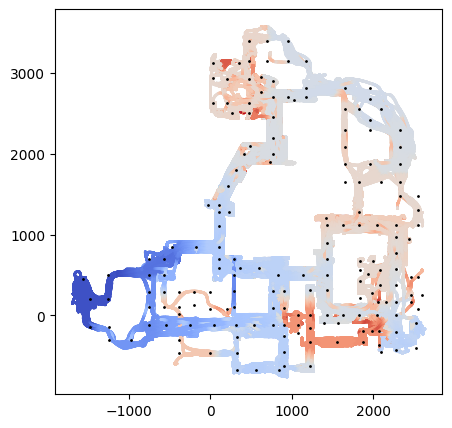

In [55]:
plt.figure(figsize=(5, 5))
plt.scatter(dem.ticks['X'], dem.ticks['Y'], c=dem.ticks['Z'], cmap='coolwarm', s=1)
nodes = pd.read_csv('../../data/inferno_graph/graph_models/manual/nodes_v1_5.csv')
plt.scatter(nodes['x'], nodes['y'], c='black', s=1)

### Graph creator test

In [2]:
tc = CS2TabularGraphDataCreator()
tc.MATCH_PATH = '../../data/matches-raw/cs2/2024/_iem-dallas-2024-g2-vs-mouz-bo3-O1BgM30a6fWPjk5gU5VUnXg2-vs-mouz-m2-nuke.dem'
tc.PLAYER_STATS_DATA_PATH = '../../data/player-stats/scraped-in-2024/2022/norm_imputed_player_stats_2022_utf.csv'
tc.MISSING_PLAYER_STATS_DATA_PATH = '../../data/player-stats/scraped-in-2024/missing_players.csv'
tc.tick_number = 16

ticks, kills, rounds, bomb, damages, smokes, infernos = tc._INIT_get_needed_dataframes()
pf = tc._PLAYER_calculate_ingame_features_from_needed_dataframes(ticks, kills, rounds, damages)
pf = tc._PLAYER_get_activeWeapon_dummies(pf)
players = tc._PLAYER_player_dataset_create(pf)
players = tc._PLAYER_get_player_overall_statistics(players)
tabular_df = tc._TABULAR_create_initial_graph_tabular_dataset(players, rounds, tc.MATCH_PATH.split('/')[-1])
tabular_df = tc._TABULAR_add_bomb_info_to_dataset(tabular_df, bomb)

e:\csgo-gnn\proj\graph_dataset\package\CS2_tabular_graph_data_creator.py:629: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  graph_data['remaining_time'] = graph_data.apply(self.__EXT_calculate_time_remaining__, axis=1)


In [5]:
tabular_df

,tick,round,player0_team_name,player0_name,player0_X,player0_Y,player0_Z,player0_pitch,player0_yaw,player0_velocity_X,player0_velocity_Y,player0_velocity_Z,player0_health,player0_armor_value,player0_active_weapon_name,player0_active_weapon_ammo,player0_total_ammo_left,player0_is_alive,player0_is_crouchign,player0_is_ducking,player0_is_duck_jumping,player0_is_walking,player0_is_spotted,player0_is_scoped,player0_is_defusing,player0_is_reloading,player0_flash_duration,player0_is_in_bombsite,player0_balance,player0_current_equip_value,player0_round_start_equip_value,CT_losing_streak,T_losing_streak,is_bomb_dropped,player0_is_shooting,player0_is_CT,player0_stat_kills,player0_stat_HS_kills,player0_stat_opening_kills,player0_stat_deaths,player0_stat_opening_deaths,player0_stat_assists,player0_stat_flash_assists,player0_stat_damage,player0_stat_weapon_damage,player0_stat_nade_damage,player0_stat_survives,player0_stat_KPR,player0_stat_ADR,player0_stat_DPR,...,player9_active_weapon_Flashbang,player9_active_weapon_Smoke Grenade,player9_active_weapon_Incendiary Grenade,player9_active_weapon_Molotov,player9_active_weapon_Decoy Grenade,player9_overall_rating_2.0,player9_overall_DPR,player9_overall_KAST,player9_overall_Impact,player9_overall_ADR,player9_overall_KPR,player9_overall_total_kills,player9_overall_HS%,player9_overall_total_deaths,player9_overall_KD_ratio,player9_overall_dmgPR,player9_overall_grenade_dmgPR,player9_overall_maps_played,player9_overall_saved_by_teammatePR,player9_overall_saved_teammatesPR,player9_overall_opening_kill_rating,player9_overall_team_W%_after_opening,player9_overall_opening_kill_in_W_rounds,player9_overall_rating_1.0_all_Career,player9_overall_clutches_1on1_ratio,player9_overall_clutches_won_1on1,player9_overall_clutches_won_1on2,player9_overall_clutches_won_1on3,player9_overall_clutches_won_1on4,player9_overall_clutches_won_1on5,freeze_end,end,winner,CT_wins,CT_alive_num,T_alive_num,CT_total_hp,T_total_hp,CT_equipment_alue,T_equipment_value,remaining_time,match_id,is_bomb_being_planted,is_bomb_being_defused,is_bomb_defused,is_bomb_planted_at_A_site,is_bomb_planted_at_B_site,bomb_X,bomb_Y,bomb_Z
0,6338,1,CT,NiKo,2585.000000,-344.000000,-351.96875,-0.973328,-169.127655,0.000000,0.000000,0.0,100,100,Knife,0.0,1.0,True,None,None,None,False,False,False,False,False,0.0,False,150,850,200,1,1,False,False,1,0,0,0,0,0,0,0,0,0,0,1,0.000000,0.000000,0.000000,...,0,0,0,0,0.0,0.780488,0.27907,0.841935,0.64486,0.735537,0.777778,0.392275,0.591171,0.32275,0.721739,0.735537,0.17,0.148551,0.5,0.611111,0.432099,0.776,0.321321,0.666667,1.0,0.371795,0.466667,0.384615,0.4,0.0,6338,10621,CT,1,5,4600,500,500,4250,4600,115.000000,_iem-dallas-2024-g2-vs-mouz-bo3-O1BgM30a6fWPjk...,0,0,0,0,0,0.0,0.0,0.0
1,6352,1,CT,NiKo,2561.477295,-348.519653,-351.96875,-0.973328,-169.127655,-2.631592,-0.505859,0.0,100,100,Knife,0.0,1.0,True,None,None,None,False,False,False,False,False,0.0,False,150,850,200,1,1,False,False,1,0,0,0,0,0,0,0,0,0,0,1,0.000000,0.000000,0.000000,...,0,0,0,0,0.0,0.780488,0.27907,0.841935,0.64486,0.735537,0.777778,0.392275,0.591171,0.32275,0.721739,0.735537,0.17,0.148551,0.5,0.611111,0.432099,0.776,0.321321,0.666667,1.0,0.371795,0.466667,0.384615,0.4,0.0,6338,10621,CT,1,5,4600,500,500,4250,4600,114.781250,_iem-dallas-2024-g2-vs-mouz-bo3-O1BgM30a6fWPjk...,0,0,0,0,0,0.0,0.0,0.0
2,6367,1,CT,NiKo,2511.274414,-358.160583,-351.96875,-0.973328,-169.127655,0.000000,0.000000,0.0,100,100,Knife,0.0,1.0,True,None,None,None,False,False,False,False,False,0.0,False,150,850,200,1,1,False,False,1,0,0,0,0,0,0,0,0,0,0,1,0.000000,0.000000,0.000000,...,0,0,0,0,0.0,0.780488,0.27907,0.841935,0.64486,0.735537,0.777778,0.392275,0.591171,0.32275,0.721739,0.735537,0.17,0.148551,0.5,0.611111,0.432099,0.776,0.321321,0.666667,1.0,0.371795,0.466667,0.384615,0.4,0.0,6338,10621,CT,1,5,4600,500,500,4250,4600,114.546875,_iem-dallas-2024-g2-vs-mouz-bo3-O1BgM30a6fWPjk...,0,0,0,0,0,0.0,0.0,0.0
3,6381,1,CT,NiKo,2461.024414,-351.072693,-351.96875,-0.695221,-171.49

<Axes: >

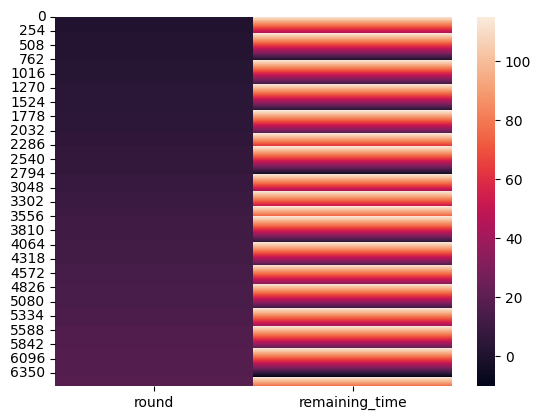

In [4]:
sns.heatmap(tabular_df[['round', 'remaining_time']])